In [1]:
#CODE RUN ON GOOGLE COLAB

from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_absolute_error
import json

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
# to load csv
dataset=pd.read_csv('eplusout_3years.csv')
dataset=dataset.drop(columns=['Unnamed: 0'])  
#print(len(dataset))
print("# features: ", len(list(dataset.columns)))
dataset.head()

# features:  17


,avg_T_in,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Wind Direction [deg](TimeStep),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Solar Azimuth Angle [deg](TimeStep),Environment:Site Solar Altitude Angle [deg](TimeStep),Whole Building:Facility Total Produced Electric Energy [J](TimeStep),Electricity:Facility [J](TimeStep),InteriorEquipment:Electricity [J](TimeStep),InteriorLights:Electricity [J](TimeStep),DistrictCooling:Facility [J](TimeStep),DistrictHeating:Facility [J](TimeStep),Carbon Equivalent:Facility [kg](TimeStep)
0,18.082821,9.027778,3.083333,102566.666667,2.421398,9.375,0.0,0.0,16.238421,-74.674509,0.0,25528.643849,25528.643849,0.0,0.0,115044.390624,0.0
1,18.076854,9.444444,3.266667,102533.333333,2.607659,7.500,0.0,0.0,7.554051,-75.081983,0.0,25528.643849,25528.643849,0.0,0.0,108907.647720,0.0
2,18.071272,9.861111,3.450000,102500.000000,2.793920,5.625,0.0,0.0,1.409081,-75.187948,0.0,25528.643849,25528.643849,0.0,0.0,102525.455986,0.0
3,18.066188,10.277778,3.633333,102466.666667,2.980182,3.750,0.0,0.0,10.318985,-74.985968,0.0,25528.643849,25528.643849,0.0,0.0,95889.187315,0.0
4,18.061773,10.694444,3.816667,102433.333333,3.166443,1.875,0.0,0.0,18.856027,-74.488165,0.0,25528.643849,25528.643849,0.0,0.0,89397.078196,0.0


In [4]:
# load dataset
values=dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of features
n_features = len(list(dataset.columns)) # number of columns in dataset
n_output = 48 # 8 hours "in the future"
n_train_stamps = 2*364*24*6 #2 years

In [5]:
def Reframing(n_stamps, n_output=n_output, scaled=scaled, n_train_stamps = n_train_stamps):

    # frame as supervised learning
    reframed = series_to_supervised(scaled, n_stamps, n_output)

    # split into train and test sets
    values = reframed.values
    train = values[:n_train_stamps, :]
    test = values[n_train_stamps:, :]

    # split into input and outputs
    n_obs = n_stamps * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_stamps, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_stamps, n_features))
    
    return train_X, train_y, test_X, test_y

In [6]:
def PlotResult(d, case, dataset=dataset, n_train_stamps = n_train_stamps):

  filename=f"n_stamps{d['n_stamps']}_epochs{d['epochs']}_batchsize{d['batch_size']}_n_units{d['n_units']}"
  history=d['history']
  inv_yhat=d['inv_yhat']

  # plot history
  fig0 = pyplot.figure()
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.xlabel('Epoch')
  pyplot.ylabel('Loss (MAE)')
  pyplot.title('Loss (MAE) for '+ case)
  pyplot.legend()
  fig0.savefig(filename+'_loss.png', dpi=120)
  pyplot.show()

  # plot prediction
  fig1 = pyplot.figure()
  pyplot.plot(dataset['avg_T_in'][n_train_stamps:].values, label='Real')
  pyplot.plot(inv_yhat, label='Predicted')
  pyplot.legend()
  pyplot.xlabel('Timestamp')
  pyplot.ylabel('Tin (°C)')
  pyplot.title("Real Tin vs. Predicted Tin for "+ case)
  fig1.savefig(filename+'_results.png', dpi=120)
  print(fig1.dpi)
  pyplot.show()

In [7]:
def ChangeModel(n_units=50, e=10, bs=72, n_stamps=6, n_output=n_output, scaled=scaled, to_reframe=False, *args):
  
  # use this when reframed is needed at each iteration of a for-loop
  if to_reframe:
    train_X, train_y, test_X, test_y = Reframing(n_stamps)
    print('reframed')
    
  else:
    train_X = args[0]
    train_y = args[1]
    test_X = args[2]
    test_y = args[3]


  # design network
  model = Sequential()
  model.add(LSTM(n_units, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam')

  # fit network
  history = model.fit(train_X, train_y, epochs=e, batch_size=bs, validation_data=(test_X, test_y), verbose=2, shuffle=False)
  


  # make a prediction
  yhat = model.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], n_stamps*n_features))
  
  # invert scaling for forecast
  inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  
  # calculate RMSE and MAE
  rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
  mae = mean_absolute_error(inv_y, inv_yhat)
  d={'n_units': n_units, 'epochs': e, 'batch_size':bs, 'n_stamps': n_stamps, 'RMSE': rmse, 'MAE': mae, "history": history, "inv_yhat": inv_yhat}
  print('\n', d)
  #print('Test RMSE: %.3f' % rmse)

  return d

In [8]:
res_stamps = []
for n_stamps in [1,6,72,144]: #10 mins, 1hr, 12hrs, 24hrs 
  res_stamps.append(ChangeModel(50, 10, 72, n_stamps, n_output, scaled, to_reframe=True))

reframed
Epoch 1/10
1456/1456 - 6s - loss: 0.0767 - val_loss: 0.1398
Epoch 2/10
1456/1456 - 4s - loss: 0.0381 - val_loss: 0.1099
Epoch 3/10
1456/1456 - 4s - loss: 0.0343 - val_loss: 0.1049
Epoch 4/10
1456/1456 - 3s - loss: 0.0333 - val_loss: 0.1002
Epoch 5/10
1456/1456 - 3s - loss: 0.0325 - val_loss: 0.0947
Epoch 6/10
1456/1456 - 3s - loss: 0.0315 - val_loss: 0.0936
Epoch 7/10
1456/1456 - 4s - loss: 0.0306 - val_loss: 0.0938
Epoch 8/10
1456/1456 - 3s - loss: 0.0295 - val_loss: 0.0925
Epoch 9/10
1456/1456 - 4s - loss: 0.0287 - val_loss: 0.0900
Epoch 10/10
1456/1456 - 4s - loss: 0.0280 - val_loss: 0.0867

 {'n_units': 50, 'epochs': 10, 'batch_size': 72, 'n_stamps': 1, 'RMSE': 0.912121496998126, 'MAE': 0.77739877, 'history': <keras.callbacks.History object at 0x7f45dc5aadd0>, 'inv_yhat': array([18.628521, 18.6164  , 18.605604, ..., 18.128094, 18.12949 ,
       18.13123 ], dtype=float32)}
reframed
Epoch 1/10
1456/1456 - 8s - loss: 0.0709 - val_loss: 0.1420
Epoch 2/10
1456/1456 - 6s - loss:

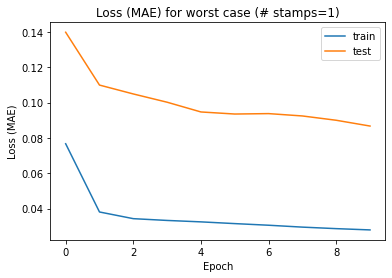

72.0


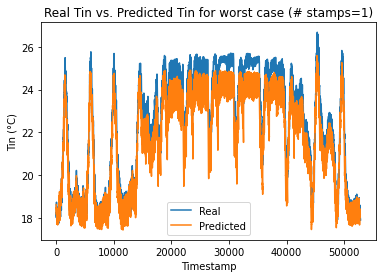

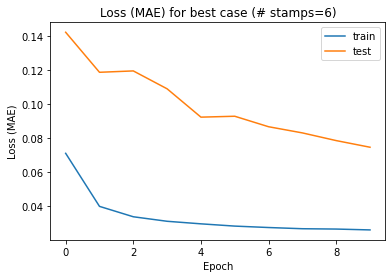

72.0


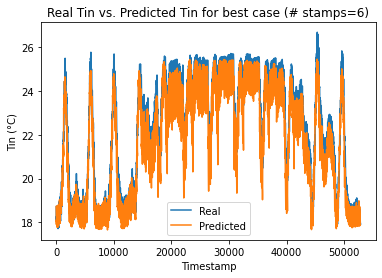

({'MAE': 0.77739877,
  'RMSE': 0.912121496998126,
  'batch_size': 72,
  'epochs': 10,
  'history': <keras.callbacks.History at 0x7f45dc5aadd0>,
  'inv_yhat': array([18.628521, 18.6164  , 18.605604, ..., 18.128094, 18.12949 ,
         18.13123 ], dtype=float32),
  'n_stamps': 1,
  'n_units': 50},
 {'MAE': 0.6670868,
  'RMSE': 0.8203465045965392,
  'batch_size': 72,
  'epochs': 10,
  'history': <keras.callbacks.History at 0x7f45d5dded50>,
  'inv_yhat': array([18.725018, 18.699293, 18.678274, ..., 17.9438  , 17.958511,
         17.969002], dtype=float32),
  'n_stamps': 6,
  'n_units': 50})

In [9]:
maxRMSE = max(res_stamps, key=lambda x:x['RMSE'])
minRMSE = min(res_stamps, key=lambda x:x['RMSE'])
opt_stamps =minRMSE['n_stamps']
PlotResult(maxRMSE, f"worst case (# stamps={maxRMSE['n_stamps']})")
PlotResult(minRMSE, f'best case (# stamps={opt_stamps})')
maxRMSE, minRMSE

In [10]:
#Reframe after deciding n_stamps
# opt_stamps = 6
train_X, train_y, test_X, test_y = Reframing(opt_stamps)

In [11]:
res_epochs = []
res_epochs.append(minRMSE)
for e in [20, 30]:
  res_epochs.append(ChangeModel(50, e, 72, opt_stamps, n_output, scaled, False, train_X, train_y, test_X, test_y))

Epoch 1/20
1456/1456 - 8s - loss: 0.0723 - val_loss: 0.1696
Epoch 2/20
1456/1456 - 6s - loss: 0.0387 - val_loss: 0.1245
Epoch 3/20
1456/1456 - 6s - loss: 0.0335 - val_loss: 0.1348
Epoch 4/20
1456/1456 - 6s - loss: 0.0315 - val_loss: 0.1143
Epoch 5/20
1456/1456 - 6s - loss: 0.0293 - val_loss: 0.0900
Epoch 6/20
1456/1456 - 6s - loss: 0.0278 - val_loss: 0.0894
Epoch 7/20
1456/1456 - 6s - loss: 0.0272 - val_loss: 0.0943
Epoch 8/20
1456/1456 - 6s - loss: 0.0266 - val_loss: 0.0897
Epoch 9/20
1456/1456 - 6s - loss: 0.0264 - val_loss: 0.0826
Epoch 10/20
1456/1456 - 6s - loss: 0.0255 - val_loss: 0.0798
Epoch 11/20
1456/1456 - 6s - loss: 0.0251 - val_loss: 0.0724
Epoch 12/20
1456/1456 - 6s - loss: 0.0247 - val_loss: 0.0719
Epoch 13/20
1456/1456 - 6s - loss: 0.0242 - val_loss: 0.0712
Epoch 14/20
1456/1456 - 6s - loss: 0.0240 - val_loss: 0.0698
Epoch 15/20
1456/1456 - 6s - loss: 0.0238 - val_loss: 0.0678
Epoch 16/20
1456/1456 - 6s - loss: 0.0235 - val_loss: 0.0671
Epoch 17/20
1456/1456 - 6s - loss

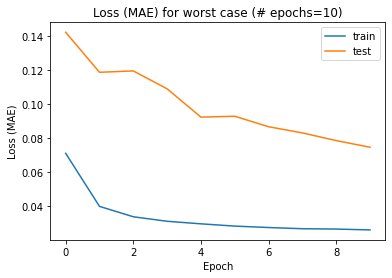

72.0


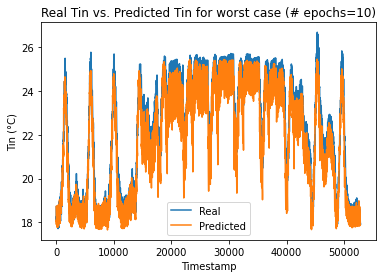

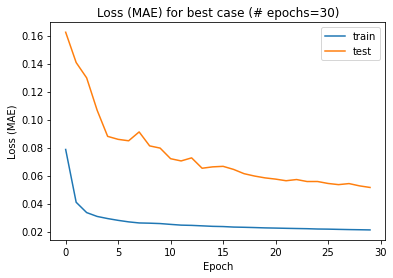

72.0


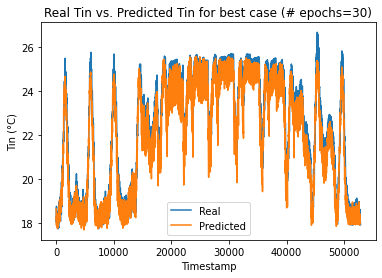

({'MAE': 0.6670868,
  'RMSE': 0.8203465045965392,
  'batch_size': 72,
  'epochs': 10,
  'history': <keras.callbacks.History at 0x7f45d5dded50>,
  'inv_yhat': array([18.725018, 18.699293, 18.678274, ..., 17.9438  , 17.958511,
         17.969002], dtype=float32),
  'n_stamps': 6,
  'n_units': 50},
 {'MAE': 0.46149957,
  'RMSE': 0.5753568153781269,
  'batch_size': 72,
  'epochs': 30,
  'history': <keras.callbacks.History at 0x7f45cdb58d90>,
  'inv_yhat': array([18.634644, 18.61572 , 18.591162, ..., 18.243206, 18.233105,
         18.221462], dtype=float32),
  'n_stamps': 6,
  'n_units': 50})

In [24]:
maxRMSE = max(res_epochs, key=lambda x:x['RMSE'])
minRMSE = min(res_epochs, key=lambda x:x['RMSE'])
opt_e =minRMSE['epochs']
PlotResult(maxRMSE, f"worst case (# epochs={maxRMSE['epochs']})")
PlotResult(minRMSE, f'best case (# epochs={opt_e})')
maxRMSE, minRMSE

In [25]:
#opt_e=30
res_batches=[]
res_batches.append(minRMSE) # we already have results for bs=72 (12hrs)
for bs in [144,288]: #24hrs, 48hrs
  res_batches.append(ChangeModel(50, opt_e, bs, opt_stamps, n_output, scaled, False, train_X, train_y, test_X, test_y))

Epoch 1/30
728/728 - 6s - loss: 0.0685 - val_loss: 0.1421
Epoch 2/30
728/728 - 4s - loss: 0.0405 - val_loss: 0.1062
Epoch 3/30
728/728 - 4s - loss: 0.0351 - val_loss: 0.0877
Epoch 4/30
728/728 - 4s - loss: 0.0327 - val_loss: 0.0769
Epoch 5/30
728/728 - 4s - loss: 0.0308 - val_loss: 0.0733
Epoch 6/30
728/728 - 4s - loss: 0.0304 - val_loss: 0.0695
Epoch 7/30
728/728 - 4s - loss: 0.0293 - val_loss: 0.0691
Epoch 8/30
728/728 - 4s - loss: 0.0282 - val_loss: 0.0673
Epoch 9/30
728/728 - 4s - loss: 0.0276 - val_loss: 0.0579
Epoch 10/30
728/728 - 4s - loss: 0.0264 - val_loss: 0.0512
Epoch 11/30
728/728 - 4s - loss: 0.0260 - val_loss: 0.0510
Epoch 12/30
728/728 - 4s - loss: 0.0258 - val_loss: 0.0491
Epoch 13/30
728/728 - 4s - loss: 0.0252 - val_loss: 0.0471
Epoch 14/30
728/728 - 4s - loss: 0.0244 - val_loss: 0.0498
Epoch 15/30
728/728 - 4s - loss: 0.0242 - val_loss: 0.0489
Epoch 16/30
728/728 - 4s - loss: 0.0241 - val_loss: 0.0446
Epoch 17/30
728/728 - 4s - loss: 0.0242 - val_loss: 0.0451
Epoch 

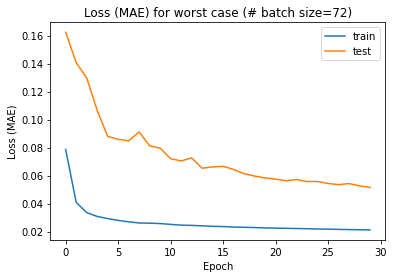

72.0


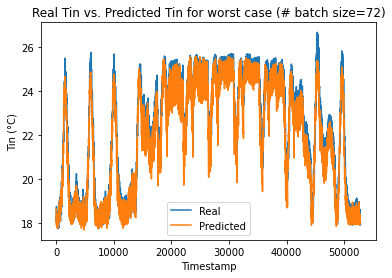

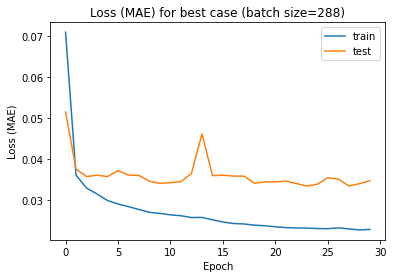

72.0


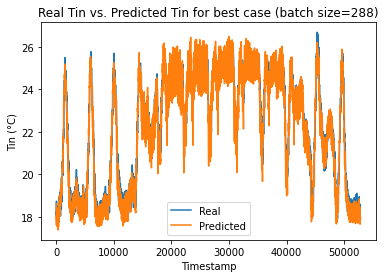

({'MAE': 0.46149957,
  'RMSE': 0.5753568153781269,
  'batch_size': 72,
  'epochs': 30,
  'history': <keras.callbacks.History at 0x7f45cdb58d90>,
  'inv_yhat': array([18.634644, 18.61572 , 18.591162, ..., 18.243206, 18.233105,
         18.221462], dtype=float32),
  'n_stamps': 6,
  'n_units': 50},
 {'MAE': 0.31161553,
  'RMSE': 0.4038414901378524,
  'batch_size': 288,
  'epochs': 30,
  'history': <keras.callbacks.History at 0x7f45c9704a10>,
  'inv_yhat': array([18.609524, 18.60022 , 18.591618, ..., 17.89909 , 17.920229,
         17.936441], dtype=float32),
  'n_stamps': 6,
  'n_units': 50})

In [26]:
maxRMSE = max(res_batches, key=lambda x:x['RMSE'])
minRMSE = min(res_batches, key=lambda x:x['RMSE'])
opt_bs =minRMSE['batch_size']
PlotResult(maxRMSE, f"worst case (# batch size={maxRMSE['batch_size']})")
PlotResult(minRMSE, f'best case (batch size={opt_bs})')
maxRMSE, minRMSE

In [28]:
#opt_e=30
#opt_bs=288
res_units=[]
res_units.append(minRMSE) # we already have results for n_units=50
for n_units in [34,68,100]: #2*features, 4*features, 50*2 
  res_units.append(ChangeModel(n_units, opt_e, opt_bs, opt_stamps, n_output, scaled, False, train_X, train_y, test_X, test_y))

Epoch 1/30
364/364 - 4s - loss: 0.0674 - val_loss: 0.0386
Epoch 2/30
364/364 - 2s - loss: 0.0345 - val_loss: 0.0340
Epoch 3/30
364/364 - 2s - loss: 0.0320 - val_loss: 0.0367
Epoch 4/30
364/364 - 2s - loss: 0.0313 - val_loss: 0.0405
Epoch 5/30
364/364 - 2s - loss: 0.0305 - val_loss: 0.0395
Epoch 6/30
364/364 - 2s - loss: 0.0299 - val_loss: 0.0380
Epoch 7/30
364/364 - 2s - loss: 0.0292 - val_loss: 0.0373
Epoch 8/30
364/364 - 2s - loss: 0.0287 - val_loss: 0.0365
Epoch 9/30
364/364 - 2s - loss: 0.0278 - val_loss: 0.0390
Epoch 10/30
364/364 - 2s - loss: 0.0269 - val_loss: 0.0384
Epoch 11/30
364/364 - 2s - loss: 0.0266 - val_loss: 0.0415
Epoch 12/30
364/364 - 2s - loss: 0.0259 - val_loss: 0.0439
Epoch 13/30
364/364 - 3s - loss: 0.0254 - val_loss: 0.0452
Epoch 14/30
364/364 - 3s - loss: 0.0252 - val_loss: 0.0425
Epoch 15/30
364/364 - 2s - loss: 0.0246 - val_loss: 0.0423
Epoch 16/30
364/364 - 2s - loss: 0.0244 - val_loss: 0.0408
Epoch 17/30
364/364 - 2s - loss: 0.0241 - val_loss: 0.0414
Epoch 

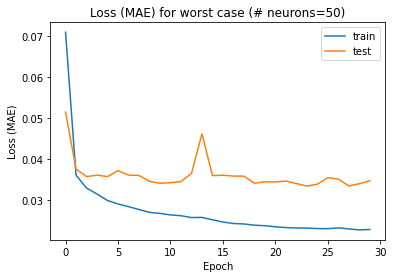

72.0


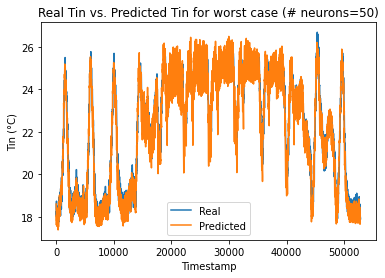

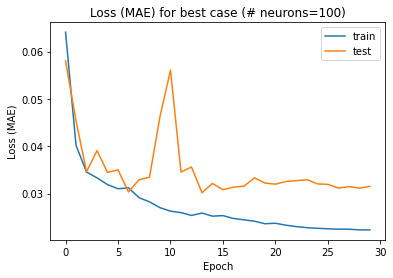

72.0


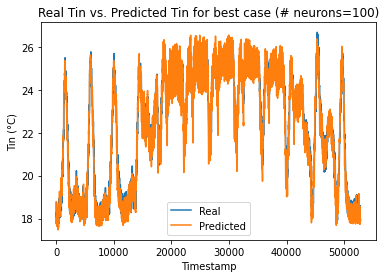

({'MAE': 0.31161553,
  'RMSE': 0.4038414901378524,
  'batch_size': 288,
  'epochs': 30,
  'history': <keras.callbacks.History at 0x7f45c9704a10>,
  'inv_yhat': array([18.609524, 18.60022 , 18.591618, ..., 17.89909 , 17.920229,
         17.936441], dtype=float32),
  'n_stamps': 6,
  'n_units': 50},
 {'MAE': 0.28259456,
  'RMSE': 0.37987998824062613,
  'batch_size': 288,
  'epochs': 30,
  'history': <keras.callbacks.History at 0x7f45c4fccf10>,
  'inv_yhat': array([18.784101, 18.75645 , 18.717438, ..., 17.976284, 17.999136,
         18.015783], dtype=float32),
  'n_stamps': 6,
  'n_units': 100})

In [29]:
maxRMSE = max(res_units, key=lambda x:x['RMSE'])
minRMSE = min(res_units, key=lambda x:x['RMSE'])
opt_units =minRMSE['n_units']
PlotResult(maxRMSE, f"worst case (# neurons={maxRMSE['n_units']})")
PlotResult(minRMSE, f'best case (# neurons={opt_units})')
maxRMSE, minRMSE

In [30]:
datastore={'opt_units': opt_units,
            'opt_e' : opt_e,
            'opt_bs': opt_bs,
            'opt_stamps': opt_stamps}

with open('opt_settings_8hrs.JSON', 'w') as f:
        json.dump(datastore, f)